In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

# 1.1 Check transects

A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.\

In [2]:
# Set inputs
fp = 'datasets' #File path
fn_tran =  'transects_coords.csv' #File name for transects


# Read data
df_tran = pd.read_csv(os.path.join(fp, fn_tran), index_col='ID')
df_tran

,Land_x,Land_y,Sea_x,Sea_y
ID,,,,
Transect1,463.810852,880.924590,748.408892,599.888166
Transect2,383.756554,792.082469,694.641549,540.433331
Transect3,316.183743,699.231069,644.833124,471.282315
Transect4,257.524125,610.852678,593.043798,393.113504
Transect5,204.799094,527.785536,538.509074,307.356214
Transect6,146.184639,442.402003,483.870858,227.919454
Transect7,87.900983,342.714416,441.075510,155.000819
Transect8,36.335441,234.596687,406.417477,82.993029
Transect9,0.000000,129.837061,378.240760,0.000000


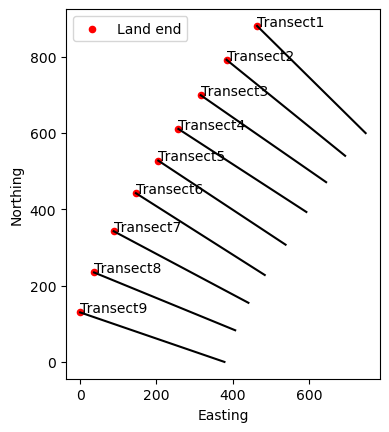

In [3]:
# Visualize transects
fig, ax = plt.subplots(1,1)

# Plot transects
ax.plot(df_tran[['Land_x', 'Sea_x']].transpose(), 
        df_tran[['Land_y', 'Sea_y']].transpose(),
        color='k')

# Highlight landward ends
df_tran.plot.scatter('Land_x', 'Land_y', c='r', 
                     label='Land end', ax=ax)


# Add transect labels
for i, row in df_tran.iterrows():
    ax.text(row['Land_x'], row['Land_y'], i)

# Set ax labels
ax.set_aspect('equal')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

ax.legend()
plt.savefig('figures/transects.jpg', dpi=300, bbox_inches='tight')

# 1.2 Check shoreline positions

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

In [4]:
fn_obs =  'shorelines_obs.csv' # File name for shoreline observation
fn_targ =  'shorelines_target.csv' # File name for shoreline target
fn_gt =  'shorelines_groundtruth.csv' #File name for groudtruth

# Read shoreline data
df_gt = pd.read_csv(os.path.join(fp, fn_gt), index_col='Datetime')
df_gt.index = pd.to_datetime(df_gt.index)
df_targ = pd.read_csv(os.path.join(fp, fn_targ), index_col='Datetime')
df_targ.index = pd.to_datetime(df_targ.index)
df_obs = pd.read_csv(os.path.join(fp, fn_obs), index_col='Datetime')
df_obs.index = pd.to_datetime(df_obs.index)
df_obs

,Transect1,Transect2,Transect3,Transect4,Transect5,Transect6,Transect7,Transect8,Transect9
Datetime,,,,,,,,,
1987-05-22 23:08:08,193.596313,193.206069,183.484031,182.999537,178.345458,182.781619,182.423618,180.652317,184.611496
1987-09-11 23:10:29,210.681254,211.017242,208.327198,208.519306,192.358667,188.768767,183.809033,175.184561,176.438575
1987-09-27 23:10:51,216.590212,218.646195,219.003388,210.751201,201.107611,203.260943,195.617559,177.395789,NaN
1987-11-14 23:11:47,204.220877,199.040433,200.969868,199.910419,187.276875,191.465551,180.601306,167.144832,170.410094
1988-02-18 23:13:23,195.191788,187.487088,197.401703,193.596704,199.793985,193.661102,193.167045,191.399071,195.001288
...,...,...,...,...,...,...,...,...,...
2018-09-16 23:43:20,213.394475,208.873642,207.614407,200.922483,189.609754,197.508301,186.292343,175.528700,NaN
2018-10-18 23:43:58,NaN,205.638208,204.622951,195.457303,201.689672,196.422823,190.711102,184.904075,NaN
2018-11-03 23:44:02,204.162356,198.982894,192.175758,202.318754,199.186722,191.612484,190.450079,181.909032,185.167295


## 1.2.1 Spatial variation

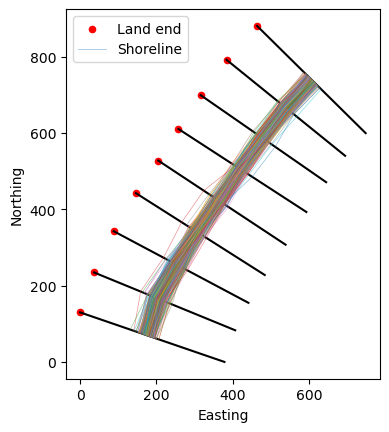

In [5]:
# Spatial view of shoreline position
land_x, land_y = df_tran['Land_x'], df_tran['Land_y'] # Land end coords
sea_x, sea_y = df_tran['Sea_x'], df_tran['Sea_y'] # Sea end coords
tran_len = np.sqrt((sea_x-land_x)**2+(sea_y-land_y)**2) # Length of transect


fig, ax = plt.subplots(1,1)

# Plot transects
ax.plot(df_tran[['Land_x', 'Sea_x']].transpose(), 
        df_tran[['Land_y', 'Sea_y']].transpose(),
        color='k')

# Plot land ends
df_tran.plot.scatter('Land_x', 'Land_y', c='r', 
                     label='Land end', ax=ax)

# Iterate dates
for date, row_obs in df_obs.iterrows():
    
    # Only label first shoreline
    if date == df_obs.index[0]:
        label_obs = 'Shoreline'
    else:
        label_obs = None
    
    # Calculate shoreline coords
    x_obs = land_x + row_obs/tran_len*(sea_x-land_x)
    y_obs = land_y + row_obs/tran_len*(sea_y-land_y)
    
    # Plot shoreline
    ax.plot(x_obs, y_obs, alpha=0.5, linewidth=0.5, label=label_obs)
        
    
    
ax.set_aspect('equal')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

ax.legend()
plt.savefig('figures/shorelines_spatial.jpg', dpi=300, bbox_inches='tight')

### 1.2.2 Temporal variation

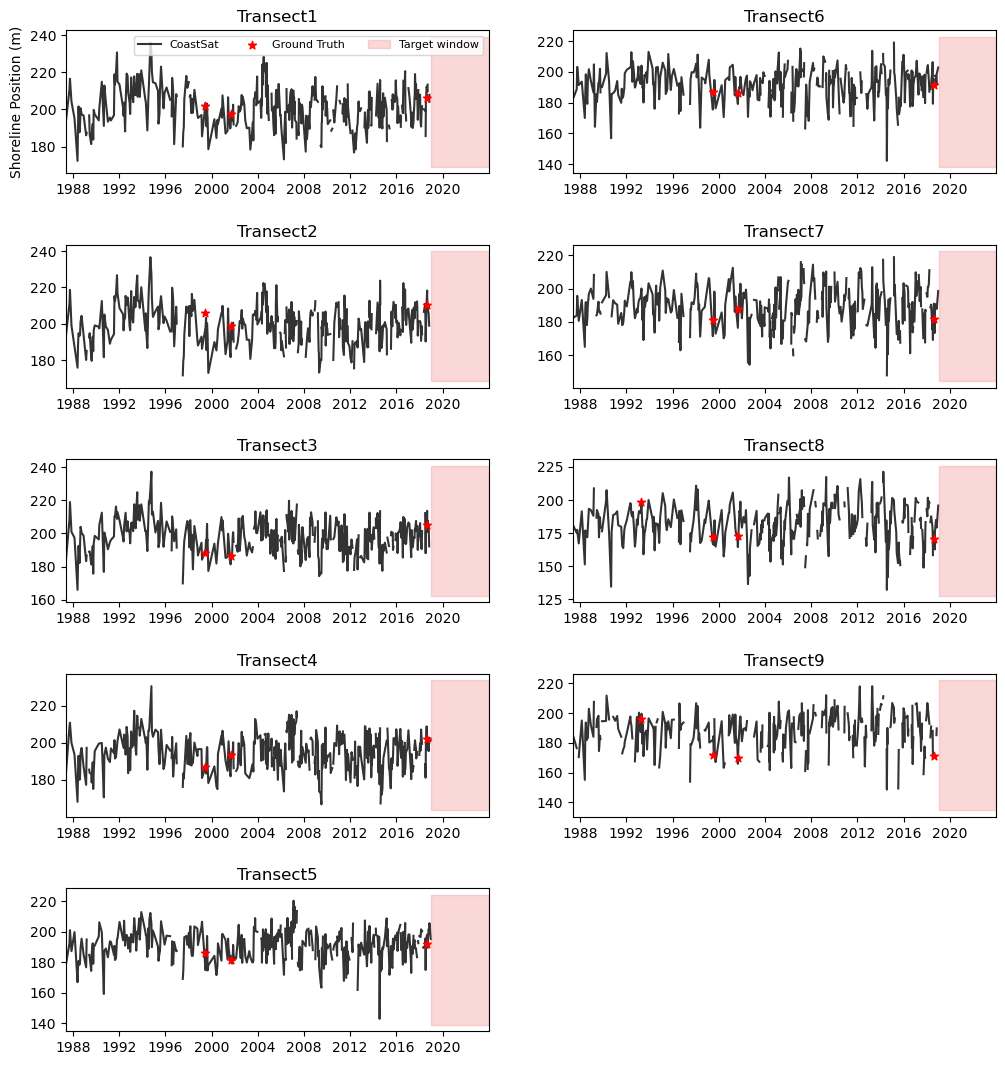

In [6]:
# Temporal view of shoreline position

fig, axes = plt.subplots(len(df_tran)//2+1, 2, figsize=(12, 13))


# Iterate transects 
for i, tran_id in enumerate(df_tran.index):
    
    ax = axes[int(i%(len(df_tran)/2)), int(i//(len(df_tran)/2))]
    
    # Plot time series of shoreline
    ax.plot(df_obs.index, df_obs[tran_id], color='k', label='CoastSat', zorder=-1, alpha=0.8)
    ax.scatter(df_gt.index, df_gt[tran_id], color='r', marker='*', label='Ground Truth', zorder=1)
    
    ax.fill_between(df_targ.index, ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.3, color='lightcoral', label='Target window')
    
    ax.set_title(tran_id)
    ax.set_xlim((df_obs.index.min(), df_targ.index.max()))
    
    if i == 0:
        ax.set_ylabel('Shoreline Position (m)')
        ax.legend(ncol=3, fontsize=8)
        
axes[-1, -1].axis('off')
fig.subplots_adjust(hspace=0.5)
plt.savefig('figures/shorelines_temporal.jpg', dpi=300, bbox_inches='tight')

# 1.3 Check Waves

Offshore wave data is from [CAWCR](https://data.csiro.au/collection/csiro:39819) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [7]:
# Read data

# Hs: Significant wave height
# Tp: Peak wave period
# Dp: Peak wave direction

WAVE_PARAMS = ['Hs', 'Tp', 'Dp'] 

dfs_wave = {}
for wave_param in WAVE_PARAMS:
    df_wave = pd.read_csv(
        os.path.join(fp, 'waves' ,'{}.csv'.format(wave_param)),
        index_col = 'Datetime'
    )
    df_wave.index = pd.to_datetime(df_wave.index)
    dfs_wave[wave_param] = df_wave
    


# 1.3.1 Check wave roses for different transects

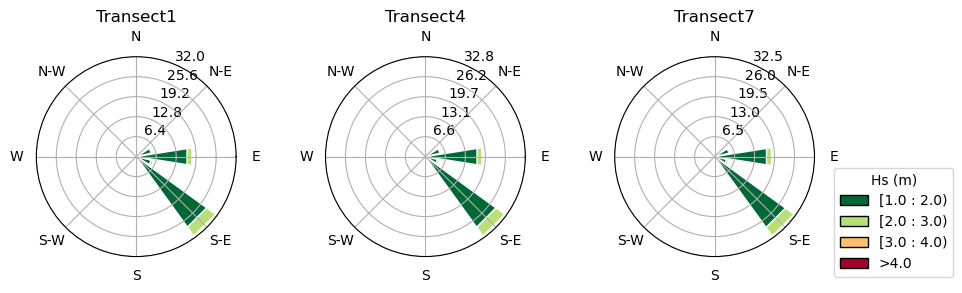

In [8]:
# Plot wave roses

tran_ids = ['Transect1', 'Transect4', 'Transect7']  # Target transects to plot

fig, axes = plt.subplots(ncols=3, figsize=(10, 3),
                        subplot_kw={'projection': 'windrose'})

for i, tran_id in enumerate(tran_ids):
    ax = axes[i]
    
    # Plot wave rose for Hs
    ax.bar(dfs_wave['Dp'][tran_id], dfs_wave['Hs'][tran_id], normed=True, opening=0.8, bins=[1, 2, 3, 4], 
        cmap=cm.RdYlGn_r, edgecolor='white')
    ax.set_title(tran_id)

    if i == 2:
        cbar = ax.legend(loc=(1.1, -0.1), title='Hs (m)')

plt.tight_layout()
plt.savefig('figures/wave_roses.jpg', dpi=300, bbox_inches='tight')

# 1.3.2 Check time series of wave parameters (Average across transects)

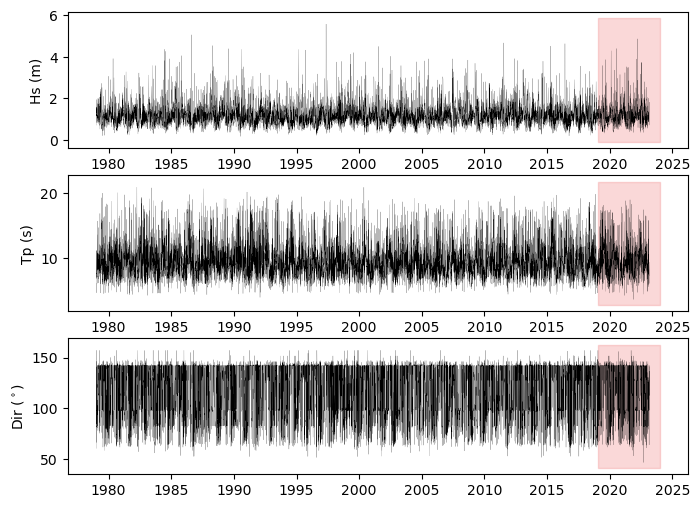

In [9]:
# Plot timeseries wave parameters averaged over transects
tran_id = 'Transect1'
labels = ['Hs (m)', 'Tp (s)', 'Dir ($^\circ$)']

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

for i, wave_param in enumerate(WAVE_PARAMS):
    # Calculate the average 
    df_mean = dfs_wave[wave_param].mean(1)
    ax = axes[i]
    ax.plot(df_mean.index, df_mean.values, color='k', linewidth=0.1)
    ax.fill_between(df_targ.index, ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.3, color='lightcoral', label='Target window')
    #ax.set_title(wave_param)
    ax.set_ylabel(labels[i])
plt.savefig('figures/wave_ts.jpg', dpi=300, bbox_inches='tight')    